In [1]:
"""
#%%
Project Steps
https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/44732d48-dcfe-4b4e-9614-12422ec29306

First steps:

Camera calibration
Distortion correction
Color/gradient threshold
Perspective transform

After doing these steps, two additional steps for the project:

Detect lane lines
Determine the lane curvature
"""
#%%
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

#%%
# ====================
# CAMERA CALIBRATION
# ====================

# prepare object points, like (0, 0, 0), (1, 0, 0), (2, 0, 0), ..., (8, 5, 0)
objp = np.zeros((6*9,3), np.float32)

# https://stackoverflow.com/questions/42308270/python-numpy-mgrid-and-reshape
# http://louistiao.me/posts/numpy-mgrid-vs-meshgrid/
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    # Convert images to grayscale in order to use cv2.findChessboardCorners
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    # If corners are found, append those points to the image points arrary
    # The prepared points, objp, are added to the object points arrary. 
    # These object points will be the same for all the calibration images since they represent a real chessboard
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    #print(ret)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img', img)
        #plt.imshow(img)
img_size = (gray.shape[1], gray.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

#%%
# we have objpoints and imgpoints needed for camera calibration. 
# now to calculate the camera matrix and distortion coefficients, 
# and then to test undistortion calibration on images
# Read in an image

#img_size = (img.shape[1], img.shape[0])
# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted destination image (dest)
def cal_undistort(img):
    # Use cv2.calibrateCamera() and cv2.undistort()
    dst = cv2.undistort(img, mtx, dist, None, mtx)  
    
    return dst

#%%
# ========================
# Color/gradient threshold
# ========================

# Lab for yellow lane and Luv for white lane color threshold
def color_white_yellow_binary(img):
    # yellow: Lab binary with b channel threshold (155, 200)
    lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    
    lab_yellow_binary = np.zeros_like(lab_img[:,:,2])
    lab_yellow_binary[(lab_img[:,:,2] >= 155) & (lab_img[:,:,2] <= 200)] = 1
    
    # white: Luv binary with L channel threshold (225, 255)
    luv_img = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)

    luv_white_binary = np.zeros_like(luv_img[:,:,0])
    luv_white_binary[(luv_img[:,:,0] >= 225) & (luv_img[:,:,0] <= 255)] = 1
    
    # Now combine both
    color_binary = np.zeros_like(luv_img[:,:,0])
    color_binary[(lab_yellow_binary == 1) | (luv_white_binary == 1)] = 1

    return color_binary

#%%
# gradient threshold

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh=(0, 255)):

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8-bit (0 - 255) and convert to type np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# combine all gradient thresholding 
def combined_gradient(img):    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements    
    # # apply gradient threshold on grayscale image 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(50, 225))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 225))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, thresh=(20, 150))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    grad_combined = np.zeros_like(dir_binary)
    grad_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return grad_combined

# combine color and gradient thresholding 
def combined_binary(img):
    color_bin = color_white_yellow_binary(img)
    grad_combined = combined_gradient(img)
    
    combined_bin = np.zeros_like(grad_combined)
    combined_bin[(grad_combined == 1) | (color_bin == 1)] = 1
    
    return combined_bin 
    
#%%
# =====================
# Perspective transform
# =====================

# define calibration box in source (orignial) and destionation (desired or warped) coordinate
src_pts = np.array([[690, 450], [1110,img.shape[0]-2],[210,img.shape[0]-2], [595, 450]], np.int32)
dst_pts = np.array([[1100,0], [1100,img.shape[0]-2],[200,img.shape[0]-2], [200, 0]], np.int32)
"""
# plot the sources points 
plt.plot(795, 515, '.') # top right 
plt.plot(1110, img.shape[0]-2, '.') # bottom right 
plt.plot(195,img.shape[0]-2, '.') # bottom left 
plt.plot(495, 515, '.') # top left 
"""
# define perspective tranform function
def warp(img, src_pts, dst_pts, flag = False):
   
    # four source coordinates
    src = src_pts.astype(np.float32)
    #four desired coordinates
    dst = dst_pts.astype(np.float32) 
    
    # compute the perspective transform matrix M for 2d images
    if flag == False:
        M = cv2.getPerspectiveTransform(src, dst)
        # create warped image using linear interpolation
        img_size = (img.shape[1], img.shape[0])
        
    # compute the perspective transform matrix M for 3d images
    elif flag == True:
        M = cv2.getPerspectiveTransform(dst, src)
        # create warped image using linear interpolation
        img_size = (img.shape[:2][1], img.shape[:2][0])
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

#%%
"""
After applying calibration, thresholding, and a perspective transform to a road image, you should 
have a binary image where the lane lines stand out clearly. However, you still need to decide 
explicitly which pixels are part of the lines and which belong to the left line and which belong to 
the right line.
"""
# =====================
# Detect Lane Lines
# =====================
def window_sliding(warped_im):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_im[warped_im.shape[0]//2:,:], axis=0)

    # This method comes from 
    # https://discussions.udacity.com/t/unable-to-draw-rectangles-on-curve-on-images/244276/61?u=jiewang
    warped_im = np.uint8(warped_im) 
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped_im, warped_im, warped_im))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint]) # np.argmax returns the indices of the maximum values along an axis
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped_im.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_im.nonzero() # np.nonzero return the indices of the elements that are non-zero.
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_im.shape[0] - (window+1)*window_height
        win_y_high = warped_im.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds) # np.concatenate join a sequence of arrays along an existing axis
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    return left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, nonzerox, nonzeroy

#%%
# Visualization
# Generate x and y values for plotting
def poly_fit(leftx, lefty, rightx, righty, warped_im):
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, warped_im.shape[0]-1, warped_im.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx

#%%
# =============================
# Calculation of Lane Curvature
# =============================
def car_movement(left_fitx, right_fitx, warped_im):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension
    
    ploty = np.linspace(0, warped_im.shape[0]-1, warped_im.shape[0] )
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # average radius of curvature is in meters
    rad_curverad = (left_curverad + right_curverad)/2
    
    # calculate the car offset
    line_ave = (left_fitx[-1] + right_fitx[-1])/2
    line_offset = line_ave - (warped_im.shape[1]//2)
    car_offset = line_offset * xm_per_pix
    
    return rad_curverad, car_offset

# %%
def fixed_frame(warped_im, undist_test_imgs, left_fitx, right_fitx):
    
    ploty = np.linspace(0, warped_im.shape[0]-1, warped_im.shape[0] )

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_im).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp =  warp(color_warp, src_pts, dst_pts, flag = True)
    # Combine the result with the original image
    fix_img = cv2.addWeighted(undist_test_imgs, 1, newwarp, 0.3, 0)
    rad_curverad, car_offset = car_movement(left_fitx, right_fitx, warped_im)
    
    car_offset = 'Car Offset: ' + '{0:.2f}'.format(car_offset) + 'm'
    rad_curverad = 'Curvature Radius:' + '{0:.2f}'.format(rad_curverad) + 'm'
    
    cv2.putText(fix_img, car_offset , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=2)
    cv2.putText(fix_img, rad_curverad , (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=2)
    
    return fix_img

def video_pipeline(img):
    
    # undistored, color and gradient thresholding mask, and warped images processing
    undist_test_imgs = cal_undistort(img)
    combined_bin = combined_binary(undist_test_imgs)
    warped_im = warp(combined_bin, src_pts, dst_pts, flag = False)
    
    # windows sliding line searching 
    left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, nonzerox, nonzeroy = window_sliding(warped_im)
    # polynomial fitting 
    left_fit, right_fit, left_fitx, right_fitx = poly_fit(leftx, lefty, rightx, righty, warped_im)
    # line drawing
    fixed_img = fixed_frame(warped_im, undist_test_imgs, left_fitx, right_fitx)
    
    return fixed_img


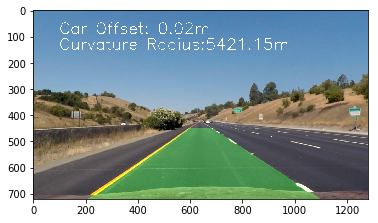

In [2]:
import matplotlib.image as mpimg
test_img = mpimg.imread('test_images/straight_lines1.jpg')
image = video_pipeline(test_img)
plt.imshow(image)

In [3]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

counter = 0
output = 'test_project1.mp4'
clip1 = VideoFileClip("project_video.mp4")

output_clip = clip1.fl_image(video_pipeline) 
%time output_clip.write_videofile(output, audio=False)

print(counter)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video test_project1.mp4
[MoviePy] Writing video test_project1.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:19<00:00,  3.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_project1.mp4 

Wall time: 6min 20s
0


In [5]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

counter = 0
output = 'test_challenge1.mp4'
clip1 = VideoFileClip("challenge_video.mp4")

output_clip = clip1.fl_image(video_pipeline) 
%time output_clip.write_videofile(output, audio=False)

print(counter)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video test_challenge1.mp4
[MoviePy] Writing video test_challenge1.mp4


100%|████████████████████████████████████████| 485/485 [02:17<00:00,  3.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_challenge1.mp4 

Wall time: 2min 18s
0
